# 

# Supervised Learning

By Spencer Cheung, Phuc Nguyen, Joey Higgins

### TODO

- Price

In [1]:
# use XGBoost
# IMF Exchange Rates, Yahoo FX (yfinance)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [3]:
lreturn = pd.read_parquet('/work/fx_log_return.parquet')
lreturn

,CNY,EUR,JPY,CAD,BRL,MXN,COP,PEN,NOK,ZAR,...,ISK,DZD,PGK,TWD,THB,AUD,IDR,KRW,MYR,NZD
0,0.007527,0.007623,0.001206,0.005128,0.006958,0.007574,0.007806,0.002674,0.009029,0.024472,...,0.004625,0.003121,0.000000,0.010105,0.005485,0.017074,0.008412,0.010502,0.001316,0.019092
1,0.004706,-0.000502,-0.003755,-0.000802,-0.001379,0.007533,0.002197,0.001638,-0.000024,0.009561,...,-0.002233,0.003724,0.038835,0.000915,0.002434,-0.000951,0.008176,0.011536,0.003958,-0.000313
2,-0.005052,0.001346,-0.000945,-0.000649,-0.006627,0.007116,0.000629,-0.002381,0.000287,0.008627,...,0.003890,0.000170,0.000000,-0.003361,-0.003041,0.002032,0.001634,-0.004880,-0.003120,0.001710
3,0.000910,0.002240,-0.001033,-0.000541,-0.009433,0.008187,0.011064,-0.001663,-0.000126,0.002932,...,0.001743,0.001018,-0.038835,0.000424,0.000608,0.004243,0.006158,0.001437,0.002279,0.012075
4,0.001229,-0.000389,-0.001622,0.000046,0.007877,-0.007774,0.002100,0.002555,0.001569,0.013339,...,-0.000830,0.001019,2.414702,0.003690,0.003683,0.004450,0.015706,0.004098,0.003465,0.006445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0.001880,0.001981,0.005436,0.001580,0.003855,-0.000024,-0.005024,-0.015778,-0.002430,0.005215,...,0.002320,0.005197,0.001490,-0.000466,-0.000621,0.004260,0.005697,0.006681,0.001186,0.000572
1799,0.000056,0.000375,0.004032,-0.000524,0.000414,0.002463,-0.001466,0.003456,-0.000455,-0.001302,...,-0.003891,-0.000255,-0.020724,0.000529,-0.007732,0.004354,-0.003302,-0.002726,0.001544,0.002501
1800,0.000000,-0.000153,0.006195,-0.001149,-0.001747,-0.003735,0.011787,0.000000,0.007453,0.003834,...,-0.001569,0.001286,0.020480,-0.000161,0.002159,0.000725,0.002334,0.000948,0.000238,0.004444
1801,0.000000,0.000845,-0.002146,-0.001534,-0.001463,0.000183,-0.001383,0.001646,-0.006147,-0.003696,...,0.003140,0.001101,-0.000122,0.002203,0.002163,-0.002635,0.002563,-0.002714,0.000476,-0.000396


In [4]:
## these are anchors with neighbors, copy and pasted from 2 - Unsupervised Learning

'''g = {"CNY": ["CDF", "LAK", "TZS", "CLP", "GNF", "PKR", "PHP", "VND", "MRU"],
     "EUR": ["ALL", "CZK", "TND", "RON", "HUF", "PLN", "RSD", "SEK", "ISK", "DZD"],
     "JPY": ["PGK", "TWD", "THB", "AUD", "IDR", "KRW", "MYR", "NZD"],}'''


     g = {'CNY': ['VND', 'MRU', 'CDF', 'PKR'],
      'EUR': ['ALL', 'CZK', 'TND', 'RON', 'RSD', 'DZD', 'HUF', 'SEK', 'ISK', 'PLN'],
      'JPY': ['MYR', 'TWD', 'THB', 'IDR', 'AUD']}

IndentationError: unexpected indent (1929528716.py, line 8)

In [11]:
# ## Need to think this through before proceeding.
# ## https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

# preparing dataframe to split

max_lag = 10
rolling_window = (10, 50)
seed = 42

def anchors_for_target(target: str, gmap: dict)-> list[str]:
    return [a for a, neighs in gmap.items() if target in neighs]

def make_panel_for_target(
    df_all: pd.DataFrame, target: str, gmap: dict,
    max_lag = 10, rolling_window = (10, 50)) -> pd.DataFrame:

    anchors = anchors_for_target(target, gmap)

    cols = {target}

    for a in anchors:
        if a in df_all.columns:
            cols.add(a)
        for n in gmap.get(a, []):
            if n in df_all.columns:
                cols.add(n)
    use_cols = sorted(cols)
    df = df_all[use_cols].copy()

    # using shift(-1) per below. 
    df["target"] = df[target].shift(-1)

    # create lags
    for col in use_cols:
        for l in range(1, max_lag + 1):
            df[f"{col}_lag_{l}"] = df[col].shift(l)


    # create rolling windows
    for col in use_cols:
        for w in rolling_window:
            df[f"{col}_ma{w}"] = df[col].rolling(w).mean().shift(1)
    return df.dropna().copy()

In [12]:
test = make_panel_for_target(lreturn, "CDF", g, max_lag = max_lag, rolling_window = rolling_window)
test

######. Guys, see if this is what we want, the entire df with lag and rolling window!!

,CDF,CLP,CNY,GNF,LAK,MRU,PHP,PKR,TZS,VND,...,MRU_ma10,MRU_ma50,PHP_ma10,PHP_ma50,PKR_ma10,PKR_ma50,TZS_ma10,TZS_ma50,VND_ma10,VND_ma50
50,0.003766,-0.000148,0.004131,-0.000818,0.000240,0.000000,0.001821,0.000143,-0.001176,0.000000,...,-0.000416,-0.000223,0.000974,0.000416,-0.001680,-0.001266,1.062247e-17,-0.000085,2.110442e-04,0.000101
51,-0.000629,0.001778,0.003764,0.000000,-0.022968,0.000000,-0.001074,-0.000072,0.000131,0.000000,...,-0.000416,-0.000223,0.000886,0.000382,-0.001666,-0.001135,-4.230797e-04,-0.000109,-2.802687e-05,0.000098
52,0.000629,0.001781,-0.000754,0.001106,0.000000,0.008333,0.001439,0.000072,0.000958,0.000000,...,-0.000416,-0.000223,0.000659,0.000372,-0.000949,-0.001098,-8.274541e-05,-0.000099,-4.667490e-18,0.000097
53,-0.003766,-0.002670,0.002382,0.001107,-0.000586,-0.001394,-0.000480,0.009414,-0.002263,0.000000,...,0.000418,-0.000050,0.000755,0.000386,-0.000043,-0.000909,-8.723204e-06,-0.000077,-1.466954e-04,0.000091
54,0.000627,0.009676,-0.000740,-0.002212,0.000469,-0.001392,0.001459,-0.009557,0.000130,0.000000,...,0.000278,-0.000078,0.000669,0.000300,0.000898,-0.000713,-2.437466e-04,-0.000131,0.000000e+00,0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,0.038308,-0.000890,-0.000155,-0.004807,-0.003947,-0.009477,0.005001,0.005554,0.001259,-0.001517,...,-0.000169,-0.000144,-0.000778,-0.000232,-0.000395,0.000012,1.251510e-03,0.000958,7.585941e-05,-0.000188
1794,0.001827,0.008089,0.000337,0.000000,0.000000,0.000000,-0.006907,-0.000178,0.001014,0.000000,...,0.000075,-0.000116,-0.000285,-0.000066,0.000107,0.000230,1.252188e-03,0.000983,-3.789367e-05,-0.000225
1795,0.000000,-0.004126,-0.002794,0.000000,0.001161,0.000000,-0.007450,0.000533,0.000000,0.000000,...,0.000100,-0.000111,-0.000364,-0.000177,0.000018,0.000226,8.520155e-04,0.001162,-1.326945e-04,-0.000209
1796,-0.040134,-0.007013,-0.000322,-0.000578,0.000000,-0.000251,-0.007463,0.000000,0.004065,0.000568,...,0.000100,-0.000111,-0.001053,-0.000568,0.000071,0.000255,-1.331400e-17,0.001181,-9.476003e-05,-0.000194


In [13]:
# do prediction, confusion matrix for classification and regression

In [14]:
# we can determin how to split the data into good proportion

In [15]:
# run functions

In [16]:
# above code is still in developement and testing

In [17]:
import xgboost as xgb
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Load the data
df_0 = pd.read_parquet('fx_log_return.parquet')[['CNY', 'CDF']]
df_0.head()

# Starting with CNY/CDF as an example
df_0['target'] = df_0['CDF'].shift(-1)

# Dropping all NA
df_0.dropna(inplace=True)

df_0.head()

,CNY,CDF,target
0,0.007527,0.000000,-0.000637
1,0.004706,-0.000637,0.000637
2,-0.005052,0.000637,-0.000637
3,0.000910,-0.000637,0.000637
4,0.001229,0.000637,-0.000637


In [18]:
# Create lag features (e.g., previous 5 days' returns)
for i in range(1, 6):
    df_0[f'Return_lag_{i}'] = df_0['CDF'].pct_change().shift(i)

# Create moving average features
df_0['MA_10'] = df_0['CDF'].rolling(window=10).mean().shift(1)
df_0['MA_50'] = df_0['CDF'].rolling(window=50).mean().shift(1)

# Drop initial rows with NaNs created by rolling windows
df_0.dropna(inplace=True)
df_0.head()
df_0 = df_0.replace([np.inf, -np.inf], np.nan).fillna(0)
df_0

,CNY,CDF,target,Return_lag_1,Return_lag_2,Return_lag_3,Return_lag_4,Return_lag_5,MA_10,MA_50
50,0.004131,0.003766,-0.000629,0.000000,-1.000000,-2.000000,0.000000,-1.000000,2.511012e-17,-0.000328
51,0.003764,-0.000629,0.000629,-7.009225,0.000000,-1.000000,-2.000000,0.000000,3.139691e-04,-0.000253
52,-0.000754,0.000629,-0.003766,-1.166922,-7.009225,0.000000,-1.000000,-2.000000,2.510985e-04,-0.000253
53,0.002382,-0.003766,0.000627,-2.000000,-1.166922,-7.009225,0.000000,-1.000000,3.139691e-04,-0.000253
54,-0.000740,0.000627,0.000000,-6.990834,-2.000000,-1.166922,-7.009225,0.000000,2.645453e-17,-0.000316
...,...,...,...,...,...,...,...,...,...,...
1788,0.000800,0.016646,0.003578,-2.000000,-2.124805,0.603662,-1.293499,0.000000,1.053190e-04,0.000126
1789,0.000604,0.003578,0.000000,4.274081,-2.000000,-2.124805,0.603662,-1.293499,1.594361e-03,0.000459
1790,0.001533,0.000000,0.000000,-0.785070,4.274081,-2.000000,-2.124805,0.603662,2.022414e-03,0.000538
1791,-0.001350,0.000000,-0.020224,-1.000000,-0.785070,4.274081,-2.000000,-2.124805,1.776246e-03,0.000538


In [21]:
# Define features (X) and target (y)
features = [col for col in df_0.columns if col not in ['target']]
X = df_0[features]
y = df_0['target']

# Time-based train-test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

xgb = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [.03, .24, .8],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [.2, .5, .8],
              'colsample_bytree': [.7],
              'n_estimators': [2, 5, 10],
              }

xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
             y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
0.005328415080134541
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 2, 'nthread': 4, 'objective': 'reg:squarederror', 'subsample': 0.8}


# Granger Causality

In [10]:
lreturn = pd.read_parquet('/work/fx_log_return.parquet')

g = {"CNY": ["CDF", "LAK", "TZS", "CLP", "GNF", "PKR", "PHP", "VND", "MRU"],
     "EUR": ["ALL", "CZK", "TND", "RON", "HUF", "PLN", "RSD", "SEK", "ISK", "DZD"],
     "JPY": ["PGK", "TWD", "THB", "AUD", "IDR", "KRW", "MYR", "NZD"]}

def granger(res, g, ml=5, a=0.05):
    x = []
    for i, j in g.items():
        for k in j:
            if i not in res.columns or k not in res.columns:
                continue
            df = pd.concat([res[k], res[i]], axis=1).dropna()
            df.columns = ["neighbor", "anchor"]
            if len(df) <= ml * 3:
                continue
            t = grangercausalitytests(df, maxlag=ml)
            pval = [t[lag][0]['ssr_ftest'][1] for lag in range(1, ml + 1)]
            min_p = float(np.min(pval))
            best_lag = int(np.argmin(pval) + 1)
            x.append({"anchor": i,
                    "neighbor": k,
                    "min_pval": round(min_p, 4),
                    "best_lag (days)": best_lag,
                    "significant": (min_p < a)})
    rdf = pd.DataFrame(x)
    return rdf

rdf = granger(lreturn,g,10,0.05)
rdf = rdf.sort_values(["anchor", "min_pval"]).reset_index(drop=True)
an = rdf[rdf["significant"]==True].sort_values(["anchor", "min_pval"])
ng = (an.groupby("anchor")["neighbor"].apply(list).to_dict())
ng

number of lags (no zero) 8
ssr based F test:         F=3.9530  , p=0.0001  , df_denom=1778, df_num=8
ssr based chi2 test:   chi2=31.9262 , p=0.0001  , df=8
likelihood ratio test: chi2=31.6456 , p=0.0001  , df=8
parameter F test:         F=3.9530  , p=0.0001  , df_denom=1778, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.5400  , p=0.0002  , df_denom=1775, df_num=9
ssr based chi2 test:   chi2=32.2009 , p=0.0002  , df=9
likelihood ratio test: chi2=31.9153 , p=0.0002  , df=9
parameter F test:         F=3.5400  , p=0.0002  , df_denom=1775, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3821  , p=0.0002  , df_denom=1772, df_num=10
ssr based chi2 test:   chi2=34.2218 , p=0.0002  , df=10
likelihood ratio test: chi2=33.8993 , p=0.0002  , df=10
parameter F test:         F=3.3821  , p=0.0002  , df_denom=1772, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8430  , p=0.0090  , df_den

{'CNY': ['VND', 'MRU', 'CDF', 'PKR'],
 'EUR': ['ALL', 'CZK', 'TND', 'RON', 'RSD', 'DZD', 'HUF', 'SEK', 'ISK', 'PLN'],
 'JPY': ['MYR', 'TWD', 'THB', 'IDR', 'AUD']}

In [8]:
an

,anchor,neighbor,min_pval,best_lag (days),significant
0,CNY,VND,0.0000,9,True
1,CNY,MRU,0.0018,10,True
2,CNY,CDF,0.0123,1,True
3,CNY,PKR,0.0201,5,True
9,EUR,ALL,0.0000,10,True
10,EUR,CZK,0.0000,3,True
11,EUR,TND,0.0000,8,True
12,EUR,RON,0.0000,1,True
13,EUR,RSD,0.0000,4,True
14,EUR,DZD,0.0000,10,True


In [9]:
# P-value: Lower is stronger correlation
# Best Lag: Strongest correlation (VND) best was 9 days after CNY
# The Euro is the strongest finding, PCA only looks at movement (not lags taken into account)
# # Run all on XGBoost and then discard if not useful

rdf

,anchor,neighbor,min_pval,best_lag (days),significant
0,CNY,VND,0.0000,9,True
1,CNY,MRU,0.0018,10,True
2,CNY,CDF,0.0123,1,True
3,CNY,PKR,0.0201,5,True
4,CNY,LAK,0.0513,2,False
5,CNY,CLP,0.1205,1,False
6,CNY,GNF,0.2345,1,False
7,CNY,TZS,0.2517,2,False
8,CNY,PHP,0.5106,9,False
9,EUR,ALL,0.0000,10,True


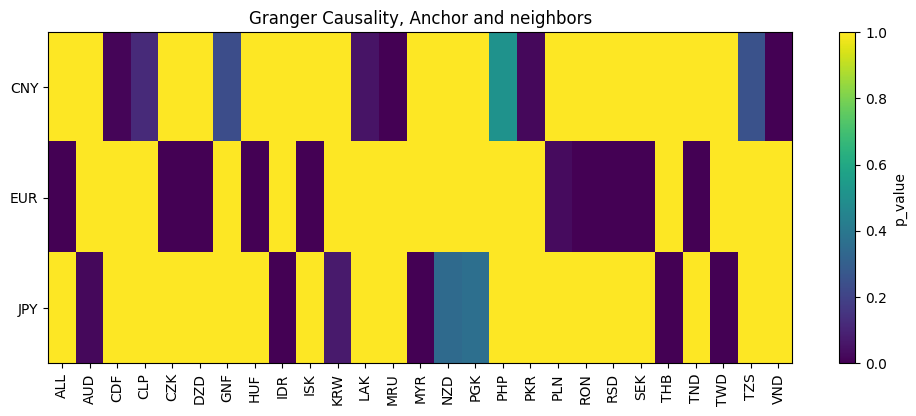

In [10]:

## Guess i will start some basic visualizations.

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# see if you guys like something like this. 

# test visualization, heatmap, neighbors to anchor, granger

pv = rdf.pivot(index = "anchor", columns = "neighbor", values = "min_pval")
pv = pv.fillna(1.0)

plt.figure(figsize = (12, 4 + 0.10 * len(pv.index)))
plt.imshow(pv.values, aspect = "auto", cmap="viridis")
plt.xticks(ticks = np.arange(pv.shape[1]), labels = pv.columns, rotation = 90)
plt.yticks(ticks = np.arange(pv.shape[0]), labels = pv.index)
plt.colorbar(label = "p_value")
plt.title("Granger Causality, Anchor and neighbors")
plt.tight_layout
plt.show()

In [11]:
# something simple to start for best_estimator_

best_model = xgb_grid.best_params_

feature_names = list(X.columns)


NameError: name 'xgb_grid' is not defined

In [14]:
# notice above is only CNY and CAD, so 

In [23]:
ls_0 = [i for i in ng.items() if i[0] == 'EUR'][0]
ls_1 = [ls_0[0] for i in range(len([i for i in ng.items() if i[0] == 'EUR'][0][1]))]
len(ls_0[1]), len(ls_1)

pd.DataFrame({'Anchor': ls_1, 'Neighbor': ls_0[1]})

,Anchor,Neighbor
0,EUR,ALL
1,EUR,CZK
2,EUR,TND
3,EUR,RON
4,EUR,RSD
5,EUR,DZD
6,EUR,HUF
7,EUR,SEK
8,EUR,ISK
9,EUR,PLN


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=619db6da-a06b-4834-b7df-60521a3a0b3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>